DesiosionTree Titanic dataset

In [41]:
import numpy as np
import pandas as pd
import collections

left_split_type = '<'
right_split_type = '>='


class DecisionTree:

    def __init__(self, max_depth, min_ginni_index=0):
        self.max_depth = max_depth
        self.root = None
        self.min_ginni_index = min_ginni_index

    def train(self, x, y):
        verify(x, y)
        self.root = self.Node(question=None, depth=0)
        self._append_nodes(self.root, x, y)
        return self.root

    def predict(self, x):
        predict = x.apply(self._calc, child=self.root, axis=1)
        return predict

    @staticmethod
    def accuracy(y, predict):
        k = y.T.to_numpy()
        c = predict.to_numpy()
        d = (k == c).astype(int).sum()
        v = k.shape[1]
        result = d / v
        return result

    def _calc(self, row, child):
        question = child.question
        if question:
            feature, value = list(question.split(left_split_type))
            is_true = row.loc[feature] < float(value)
            if is_true:
                return self._calc(row, child.left_child)
            else:
                return self._calc(row, child.right_child)
        else:
            return child.response

    def _stop(self, node):
        pass

    def _append_nodes(self, parent, x, y):
        if (not self.max_depth <= parent.depth and len(y) > 2) and not entropy(y) <= self.min_ginni_index:
            feature, value, max_ig = best_split(x, y)
            parent.question = str(feature) + left_split_type + str(value)
            x_left, y_left, x_right, y_right = split_data(x, y, parent.question)
            parent.left_child = self.Node(None, self._response(y_left), parent.depth + 1)
            parent.right_child = self.Node(None, self._response(y_right), parent.depth + 1)
            self._append_nodes(parent.left_child, x_left, y_left)
            self._append_nodes(parent.right_child, x_right, y_right)
        else:
            return

    @staticmethod
    def _response(y):
        number_true = y.sum()[0]
        number_false = y.shape[0] - number_true
        return (number_true > number_false).astype('int')

    class Node:
        def __init__(self, question=None, response=0, depth=0):
            self.left_child = None
            self.right_child = None
            self.question = question
            self.response = response
            self.depth = depth


def entropy(y):
    """ Entropy measures the degree of uncertainty,
     impurity or disorder of a random variable

    :param target: (list) target values
    :return: (float)  entropy of the array
    """

    counter = collections.Counter(y)
    p = y.value_counts().to_numpy() / len(y)
    return -np.sum(p * np.log2(p))


def verify(x, y):
    if (isinstance(x, pd.DataFrame) and isinstance(y, pd.DataFrame)):
        pass
    else:
        raise TypeError("x and y must be Pandas DataFrame")


def best_split(x, y):
    k = x.apply(best_split_value, y=y.squeeze(), split_type=left_split_type)
    gini_values = k.iloc[1]  # index 1 refers to gini values
    max_value = gini_values.max()
    index = np.where(gini_values == max_value)[0][0]

    val = k.iloc[:, [index]].loc[0]
    best_value = val.values[0]
    best_feature = val.index[0]
    return best_feature, best_value, max_value


def best_split_value(series, y, split_type):
    values = series.unique()
    inf_gain_values = []
    feature_values = []

    for val in values:
        if split_type == '<':
            mask = series < val
        else:
            mask = series >= val

        i_g = information_gain(y, mask, func=entropy)
        inf_gain_values.append(i_g)
        feature_values.append(val)

    max_inf_gain = np.max(inf_gain_values)
    index = inf_gain_values.index(max_inf_gain)
    best_feature_value = feature_values[index]

    return best_feature_value, max_inf_gain


def information_gain(y, mask, func=entropy):
    """Information gain is used for determining the best
   features/attributes that render maximum information about a class.

   :param y: (list) target values
   :param mask:(list of booleans) used for splitting the data
   :param func: (function) function for measurements of impurity/uncertainty
   :return: (float) Information Gain
   """
    if isinstance(y, pd.Series):
        y_right = y[mask]
        y_left = y[-mask]
        size = len(y)
        w_right, w_left = len(y_right) / size, len(y_left) / size
        information_gain = entropy(y) - (w_right * entropy(y_right) + w_left * entropy(y_left))
        return information_gain

    else:
        raise TypeError("y must be a Pandas Series")


def best_split(x, y):
    k = x.apply(best_split_value, y=y.squeeze(), split_type=left_split_type)

    gini_values = k.iloc[1]  # index 1 refers to gini values
    max_value = gini_values.max()
    index = np.where(gini_values == max_value)[0][0]
    val = None
    try:
        val = k.iloc[:, [index]].loc[0]
    except Exception:
        print('Caught Value Exception : ' + val)

    best_value = val.values[0]
    best_feature = val.index[0]
    return best_feature, best_value, max_value


def split_data(x, y, question):
    feature, value = list(question.split(left_split_type))
    if left_split_type == '<':
        mask = x[feature] < float(value)
    else:
        mask = x[feature] >= value

    x_left = x[mask]
    x_right = x[-mask]
    y_left = y[mask]
    y_right = y[-mask]

    return x_left, y_left, x_right, y_right

In [26]:
data = pd.read_csv("../../../resources/data/500_Person_Gender_Height_Weight_Index.csv")

#data.drop('Gender', axis=1, inplace=True)

data['obese'] = (data.Index > 4).astype('int')

data.drop('Index', axis=1, inplace=True)
x = data.drop(['obese'], axis=1)
x = pd.get_dummies(x, dummy_na=True)
y = data[['obese']]
#print(data)
tree = DecisionTree(max_depth=10)

tree.train(x, y)
y_predict = tree.predict(x)
acc = tree.accuracy(y, y_predict)
print(acc)

0.994


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score as acc

<h2> Import data </h2>

In [75]:
df_train = pd.read_csv("../../../resources/data/titanic/train.csv")
#combine = pd.concat([train.drop('Survived',1),test])

In [76]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [77]:
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
# Store target variable of training data in a safe place
survived_train = df_train[['Survived']]

survived_train.shape

(891, 1)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [88]:
# Dealing with missing numerical variables
df_train['Age'] = df_train.Age.fillna(data.Age.median())
df_train['Fare'] = df_train.Fare.fillna(data.Fare.median())

# Check out info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex_male  1309 non-null   uint8  
 1   Fare      1309 non-null   float64
 2   Age       1309 non-null   float64
 3   Pclass    1309 non-null   int64  
 4   SibSp     1309 non-null   int64  
dtypes: float64(2), int64(2), uint8(1)
memory usage: 52.4 KB


In [89]:
# Tranform Sex feature to numeric value
# create a new column for each of the options in 'Sex'
# creates a new column for female, called 'Sex_female', 
# creates a new column for 'Sex_male'
# more then two categorical values it is better to use one-hot-encode
data = pd.get_dummies(df_train, columns=['Sex'], drop_first=True)
data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [90]:
# Select features columns
x = data[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
x.head()


,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [91]:
y= survived_train
y.shape

(891, 1)

In [92]:
x.shape

(891, 5)

In [114]:
# split it back into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, survived_train, test_size=0.33, random_state=42, stratify=y)
X_train

,Sex_male,Fare,Age,Pclass,SibSp
381,0,15.7417,1.0,3,0
325,0,135.6333,36.0,1,0
125,1,11.2417,12.0,3,1
597,1,0.0000,49.0,3,0
85,0,15.8500,33.0,3,3
...,...,...,...,...,...
476,1,21.0000,34.0,2,1
299,0,247.5208,50.0,1,0
736,0,34.3750,48.0,3,1
462,1,38.5000,47.0,1,0


In [151]:

tree = DecisionTree(max_depth=10)

tree.train(X_train, y_train)
#


In [152]:
y_predict_test = tree.predict(X_test)

In [153]:
scorre = acc(y_predict_test,y_test)
scorre

0.7898305084745763

In [154]:
y_predict_train = tree.predict(X_train)

In [155]:
scorre = acc(y_predict_train,y_train)
scorre

0.9194630872483222

What is Bias-Variance Trade-off?
During training, the tree will continue to grow until each region contains exactly one training point (100% training accuracy). This results in a full classification tree which splits the training data until each leave contains a single observation. In order words, the full tree would over-fit to training data.
Over-fitting
An over-fitted tree would achieve a perfect classification of the training observations and the bias (error) would be 0. However, such a tree would be very sensitive because little changes of training observations would cause the predicted classes to change largely, this means the model variance would be very high. The model would not generalize well on unseen data.<br>
Trade-off <br>
In order to prevent over-fitting from happening, we need to define a stopping condition. A tree of low depth is unable to capture the nonlinear boundary separating the classes. By reducing the tree depth, we increase the biais (missclassification error on training) but we also reduce the variance. Bias-variance trade-off seeks a compromise between bias and variance, here using cross-validation. <br>
What is Cross-Validation? <br>
The appropriate depth can be determined by evaluating the tree on a held-out data set via cross-validation. By re-sampling the data many times, splitting the into training and validation folds, fitting trees with different sizes on the training folds and looking at the classification accuracy on the validation folds, we are able to find the tree depth, which gives the best bias-variance trade-off. Such a tree does not predict perfectly on the training set (acceptable bias) but its performance will be approximately the same if we change the training set a bit (acceptable variance). <br>
https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6


In [167]:
#cross validation
scores_test_data =  []
scores_train_data = []
depths = [3,4,8,16,20,30] 
for i in depths:
    tree = DecisionTree(max_depth=i)
    tree.train(X_train, y_train)
    y_predict_test = tree.predict(X_test)
    y_predict_train = tree.predict(X_train)
    score_test_data  =  acc(y_predict_test,y_test)
    score_train_data  =  acc(y_predict_train,y_train)
    scores_test_data.append(score_test_data)
    scores_train_data.append(score_train_data)
    
    

In [173]:
depths = [3,4,8,16,20,30] 

In [174]:
scores_test_data

[0.7966101694915254,
 0.8,
 0.7864406779661017,
 0.7728813559322034,
 0.7694915254237288,
 0.7694915254237288]

In [175]:
scores_train_data

[0.8305369127516778,
 0.8473154362416108,
 0.8959731543624161,
 0.9496644295302014,
 0.9546979865771812,
 0.9546979865771812]

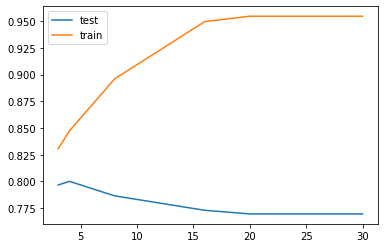

In [176]:
plt.plot(depths,scores_test_data,label='test')
plt.plot(depths,scores_train_data,label='train')
plt.legend()